## Exercise 1
#### A data scientist is running an AdaBoost classifier on a dataset with 100 observations. Answer the following:
#### (a) What is the weight initial weight of observation 72th in the training dataset? Be specific.

 The initial weight will be 1/100 = 0.01. That is because at first, all observations start with the same initial weight.

#### (b) The 72th observation in the training dataset is misclassified by the first weak learner chosen by the data scientist. Is the new weight of the 72th observation in the training dataset (i.e., the weight assigned to the 72th observation after choosing the first weak classifier) larger or smaller than the weight assigned to that observation initially? Be specific.

The new weight of the 72th observation in the training dataset is larger than the weight assigned to that observation initially. That is because by increasing the weight of a misclassified by the weak learner, the model is being forced to learn from its mistakes.

## Exercise 2
#### Explain why AbaBoost.M1 is an ensemble learning algorithm? Be specific

AdaBoost.M1 is an ensemble learning algorithm because it combines the predictions of several weak learner into one single prediction. This combination is achieved by taking the sign of the sum the products of the estimator weight, alpha(i), and the prediction of each weak learner.

## Exercise 3
#### Suppose you are running AdaBoost.M1 (with η = 0.1) with 4 training examples. At the start of the current iteration, the four examples have the weights shown in the following table. Another column says if the weak classifier got them correct or incorrect. Determine the new weights for these four examples, and fill in the corresponding entries in the table. Show all your work.

In [45]:
epsilon = (.16*0 + .64*0 + .08*1 + .12*1)/(.16 + .64 + .08 + .12)
epsilon

0.2

In [46]:
import numpy as np
alpha = np.log((1-.2)/.2)
alpha

1.3862943611198906

In [47]:
#w1 = obsw*e**(n*alpha*-1 or 1
w1 = .16*((np.e)**(.01*alpha*-1))
w2 = .64*((np.e)**(.01*alpha*-1))
w3 = .08*((np.e)**(.01*alpha*1))
w4 = .12*((np.e)**(.01*alpha*1))

In [48]:
tot_w = w1 + w2 + w3 + w4
tot_w

0.9917780595526932

In [49]:
(w1/tot_w) + (w2/tot_w) + (w3/tot_w) + (w4/tot_w)

1.0

In [50]:
import pandas as pd
example = pd.DataFrame({"Observation": [1, 2, 3, 4],
                       "Old_Weight": [0.16, 0.64, 0.08, 0.12],
                       "Correct?": ["Correct", "Correct", "Incorrect", 'Incorrect'],
                       "New_Weight": [round((w1/tot_w), 3), round((w2/tot_w), 3), round((w3/tot_w), 3), round((w4/tot_w), 3)]})
example.head()

Observation  Old_Weight   Correct?  New_Weight
0            1        0.16    Correct       0.159
1            2        0.64    Correct       0.636
2            3        0.08  Incorrect       0.082
3            4        0.12  Incorrect       0.123

In [51]:
np.sum(example['New_Weight'])

1.0

## Exercise 4
#### If your AdaBoost ensemble under-fits the training dataset, what would you do to fix that? That is, which hyper-parameters should you tweak?

I would probably increase the number of estimators and maybe increase the learning rate.

## Exercise 5
#### For binary classification, which of the following statements are TRUE of AdaBoost with decision trees as learners?
#### (a) It usually has lower bias than a single decision tree.
#### (b) It is popular because it usually works well even before any hyper-parameter tuning.
#### (c) It assigns higher weights to observations that have been misclassified.
#### (d) It can train multiple decision trees in parallel
#### (e) All of the above.
#### (f) None of the above.

(a) It usually has lower bias than a single decision tree.\
(b) It is popular because it usually works well even before any hyper-parameter tuning.\
(c) It assigns higher weights to observations that have been misclassified.

In [52]:
## Question 6
#(a)
import boto3
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR, SVC

# Defining s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'gabrielferreira-data-455-bucket'
bucket = s3.Bucket(bucket_name)

# Defining the file to be read from s3 bucket
key_file = 'framingham.csv'

bucket_object = bucket.Object(key_file)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# Reading csv
heart = pd.read_csv(file_content_stream)

# (b)
heart = heart.dropna()
heart.head(1)

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   

   TenYearCHD  
0           0

In [53]:
# Defining predictors and target variables
X = heart[['age', 'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose']]
Y = heart['TenYearCHD']

scaler = MinMaxScaler()

# Creating list to compute recall_score
RF_recall = list()
Ada_recall = list()
SVM_recall = list()

# Creating for loop to get 100 recall score to each model
for i in range(0,25):
    
    # Splitting the data into train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    # Transforming all the input variables to 0-1 scale
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    #### Random Forest model
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)
    
    # Predicting on test daset
    rf_pred = rf_md.predict_proba(X_test)[:,1]
    rf_pred = np.where(rf_pred < 0.1, 0, 1)
    
    # Computing recall score
    RF_recall.append(recall_score(Y_test, rf_pred))
    
    #### AdaBoost Classifier
    Ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500).fit(X_train, Y_train)
    
    # Predicting on test
    ADA_pred = Ada_md.predict_proba(X_test)[:,1]
    ADA_pred = np.where(ADA_pred < 0.1, 0, 1)

    # Computing the recall
    Ada_recall.append(recall_score(Y_test, ADA_pred))
    
    #### SVM
    svm_model = AdaBoostClassifier(base_estimator = SVC(kernel = 'rbf', probability = True), n_estimators = 50).fit(X_train, Y_train)
    
    # Predicting on test
    svm_pred = svm_model.predict_proba(X_test)[:,1]
    svm_pred = np.where(svm_pred < 0.1, 0, 1)

    # Computing the recall
    SVM_recall.append(recall_score(Y_test, svm_pred))

In [ ]:
# Creating for loop to get 100 recall score to each model
for i in range(0,25):
    
    # Splitting the data into train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    # Transforming all the input variables to 0-1 scale
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    #### Random Forest model
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)
    
    # Predicting on test daset
    rf_pred = rf_md.predict_proba(X_test)[:,1]
    rf_pred = np.where(rf_pred < 0.1, 0, 1)
    
    # Computing recall score
    RF_recall.append(recall_score(Y_test, rf_pred))
    
    #### AdaBoost Classifier
    Ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500).fit(X_train, Y_train)
    
    # Predicting on test
    ADA_pred = Ada_md.predict_proba(X_test)[:,1]
    ADA_pred = np.where(ADA_pred < 0.1, 0, 1)

    # Computing the recall
    Ada_recall.append(recall_score(Y_test, ADA_pred))
    
    #### SVM
    svm_model = AdaBoostClassifier(SVC(kernel = 'rbf', probability = True), n_estimators = 50).fit(X_train, Y_train)
    
    # Predicting on test
    svm_pred = svm_model.predict_proba(X_test)[:,1]
    svm_pred = np.where(svm_pred < 0.1, 0, 1)

    # Computing the recall
    SVM_recall.append(recall_score(Y_test, svm_pred))

In [ ]:
# Creating for loop to get 100 recall score to each model
for i in range(0,25):
    
    # Splitting the data into train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    # Transforming all the input variables to 0-1 scale
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    #### Random Forest model
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)
    
    # Predicting on test daset
    rf_pred = rf_md.predict_proba(X_test)[:,1]
    rf_pred = np.where(rf_pred < 0.1, 0, 1)
    
    # Computing recall score
    RF_recall.append(recall_score(Y_test, rf_pred))
    
    #### AdaBoost Classifier
    Ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500).fit(X_train, Y_train)
    
    # Predicting on test
    ADA_pred = Ada_md.predict_proba(X_test)[:,1]
    ADA_pred = np.where(ADA_pred < 0.1, 0, 1)

    # Computing the recall
    Ada_recall.append(recall_score(Y_test, ADA_pred))
    
    #### SVM
    svm_model = AdaBoostClassifier(SVC(kernel = 'rbf', probability = True), n_estimators = 50).fit(X_train, Y_train)
    
    # Predicting on test
    svm_pred = svm_model.predict_proba(X_test)[:,1]
    svm_pred = np.where(svm_pred < 0.1, 0, 1)

    # Computing the recall
    SVM_recall.append(recall_score(Y_test, svm_pred))

In [ ]:
# Creating for loop to get 100 recall score to each model
for i in range(0,25):
    
    # Splitting the data into train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    # Transforming all the input variables to 0-1 scale
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    #### Random Forest model
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)
    
    # Predicting on test daset
    rf_pred = rf_md.predict_proba(X_test)[:,1]
    rf_pred = np.where(rf_pred < 0.1, 0, 1)
    
    # Computing recall score
    RF_recall.append(recall_score(Y_test, rf_pred))
    
    #### AdaBoost Classifier
    Ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500).fit(X_train, Y_train)
    
    # Predicting on test
    ADA_pred = Ada_md.predict_proba(X_test)[:,1]
    ADA_pred = np.where(ADA_pred < 0.1, 0, 1)

    # Computing the recall
    Ada_recall.append(recall_score(Y_test, ADA_pred))
    
    #### SVM
    svm_model = AdaBoostClassifier(SVC(kernel = 'rbf', probability = True), n_estimators = 50).fit(X_train, Y_train)
    
    # Predicting on test
    svm_pred = svm_model.predict_proba(X_test)[:,1]
    svm_pred = np.where(svm_pred < 0.1, 0, 1)

    # Computing the recall
    SVM_recall.append(recall_score(Y_test, svm_pred))

In [ ]:
# Creating a data-frame with the computed recall values
model_recalls = pd.DataFrame({"RF_Recall": RF_recall,
                              "Ada_recall": Ada_recall,
                              "SVM_recall": SVM_recall})
model_recalls.shape

(100, 3)

In [ ]:
# Getting the average recall score of the 3 models
model_recalls = np.mean(model_recalls, axis = 0).sort_values(ascending = False)
model_recalls

SVM_recall    1.000000
Ada_recall    1.000000
RF_Recall     0.926786
dtype: float64

Text(0.5, 0, 'Interation number')

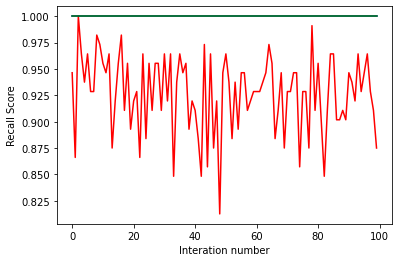

In [64]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(RF_recall, color = "red")
plt.plot(Ada_recall, color = "blue")
plt.plot(SVM_recall, color = "green")
plt.ylabel("Recall Score")
plt.xlabel("Interation number")

I would use AdaBoost Classifier with Decision Tree Classifier. Although support vector machine also had the same perfect recall values, it too computerly expensive. Therefore, AdaBoost Classifier with Decision Tree Classifier had the best performance.